In [1]:
import pandas as pd

blood_transfusion = pd.read_csv("../datasets/blood_transfusion.csv")
target_name = "Class"
data = blood_transfusion.drop(columns=target_name)
target = blood_transfusion[target_name]

In [2]:
target.nunique()

2

In [3]:
target.value_counts()

not donated    570
donated        178
Name: Class, dtype: int64

In [4]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier()

In [5]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, data, target, cv=10, scoring="balanced_accuracy")

In [6]:
scores = cv_results["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

The mean cross-validation accuracy is: 0.500 +/- 0.000


In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=1))

In [8]:
model.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'kneighborsclassifier': KNeighborsClassifier(n_neighbors=1),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 1,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

In [9]:
cv_results = cross_validate(model, data, target, cv=10, scoring="balanced_accuracy",
                           return_train_score=True)

In [10]:
import pandas as pd

cv_results = pd.DataFrame(cv_results)
cv_results.head()

,fit_time,score_time,test_score,train_score
0,0.009134,0.010810,0.513158,0.897509
1,0.007679,0.006155,0.491228,0.885953
2,0.005310,0.005606,0.587719,0.879904
3,0.005350,0.005793,0.271930,0.882828
4,0.005193,0.006360,0.385965,0.893579


In [11]:
scores = pd.DataFrame()
scores[["train error", "test error"]] = -cv_results[
    ["train_score", "test_score"]]

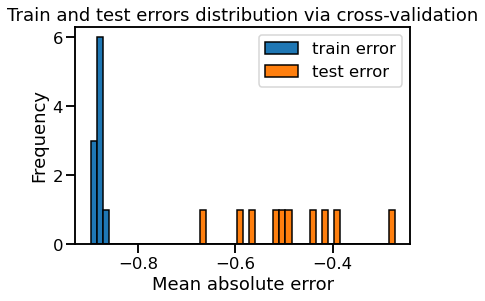

In [12]:
import matplotlib.pyplot as plt

scores.plot.hist(bins=50, edgecolor="black")
plt.xlabel("Mean absolute error")
_ = plt.title("Train and test errors distribution via cross-validation")

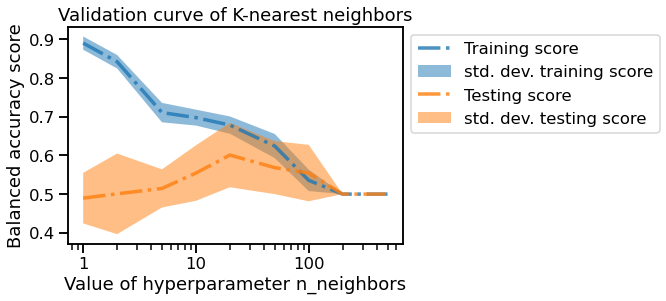

In [40]:
from sklearn.model_selection import validation_curve
import matplotlib
import matplotlib.pyplot as plt

param_range = [1, 2, 5, 10, 20, 50, 100, 200, 500]
param_name = "kneighborsclassifier__n_neighbors"
train_scores, test_scores = validation_curve(
    model, data, target, param_name=param_name, param_range=param_range, cv=5,
    n_jobs=2, scoring="balanced_accuracy")

_, ax = plt.subplots()
for name, scores in zip(
    ["Training score", "Testing score"], [train_scores, test_scores]
):
    ax.plot(
        param_range, scores.mean(axis=1), linestyle="-.", label=name,
        alpha=0.8)
    ax.fill_between(
        param_range, scores.mean(axis=1) - scores.std(axis=1),
        scores.mean(axis=1) + scores.std(axis=1),
        alpha=0.5, label=f"std. dev. {name.lower()}")

ax.set_xticks(param_range)
ax.set_xscale("log")
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xlabel("Value of hyperparameter n_neighbors")
ax.set_ylabel("Balanced accuracy score")
ax.set_title("Validation curve of K-nearest neighbors")
_ = ax.legend(bbox_to_anchor=(1., 1.))

Underfitting happens when the gap between train and test scores is low and that both scores are low. When n_neighbors is high, underfitting occurs. The model lacks expressivity because it always considers the majority class of a large number of data points. Its prediction tends to be always the same, irrespective of the test point of interest.

Overfitting happens when the gap between train and test scores is high and that the test score is low. When n_neighbors is low, the model looks at small number of data points around the test points of interest. In this case the model is too flexible: it is sensible to noise rather than the underlying structure of the data.

Generalization happens when the gap between train and test scores is relatively low and that the test scores is maximum. In our case, the range between 20 to 50 neighbors seems to be the best. Indeed, for 20 neighbors, the gap between train and test scores is larger than with 50 neighbors; however the test score is better with 20 neighbors.

Considering an intermediate value for n_neighbors makes it possible to limit overfitting by averaging out the influence of a few noisy samples. On the other hand, the model can also avoid underfitting by focusing its decision on the details of a region of interest close to the test sample. The optimum value for n_neighbors is typically very dataset-dependent and can be influenced by the choice of the distance metric, the scaling of the features, the presence of noisy samples, the balance between classes, etc.

Finally notice that, while k-nearest neighbors is useful baseline, it can be too slow to predict on large datasets with many samples and features.
Practitioners would instead favor other models such as gradient boosted trees for instance. On the particular dataset used for this quiz, the best accuracy achieved by the nearest neighbors model does not seem to be high enough to make it useful in practice.